# Question Difficulty Classification Model Training

This notebook trains a Logistic Regression model to classify question difficulty based on the question body text.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os
import joblib
import re

## 1. Load Data

In [2]:
df = pd.read_csv('../data/processed/processed_questions.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (15000, 11)


,Id,question_score,Title,question_body,max_answer_score,avg_answer_score,answer_score_variance,answer_count,ratio,difficulty_score,difficulty_label
0,469,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,12.0,4.750000,24.916667,4.0,2.400000,0.388235,medium
1,502,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,25.0,12.000000,139.000000,3.0,6.250000,0.252874,easy
2,535,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,23.0,12.833333,66.166667,6.0,3.285714,0.335556,medium
3,594,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,25.0,15.333333,112.333333,3.0,6.250000,0.252874,easy
4,683,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,29.0,6.857143,105.476190,7.0,3.625000,0.320721,easy


## 2. Preprocessing

We only need `question_body` and `difficulty_label`.

In [3]:
df = df[['question_body', 'difficulty_label']]

# Basic cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Remove HTML tags
    text = re.sub('<[^>]*>', '', text)
    # Remove special characters and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Lowercase
    text = text.lower().strip()
    return text

df['clean_body'] = df['question_body'].apply(clean_text)
df.head()

,question_body,difficulty_label,clean_body
0,<p>I am using the Photoshop's javascript API t...,medium,i am using the photoshop s javascript api to f...
1,<p>I have a cross-platform (Python) applicatio...,easy,i have a cross platform python application w...
2,<p>I'm starting work on a hobby project with a...,medium,i m starting work on a hobby project with a py...
3,<p>There are several ways to iterate over a re...,easy,there are several ways to iterate over a resul...
4,<p>I don't remember whether I was dreaming or ...,easy,i don t remember whether i was dreaming or not...


## 3. Vectorization & Split

In [4]:
X = df['clean_body']
y = df['difficulty_label']

# Split 70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Vectorize with stop words exclusion
vectorizer = CountVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")

Vocabulary size: 31555


## 4. Model Training

In [5]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Accuracy: 0.6573


## 5. Evaluation

Classification Report:
              precision    recall  f1-score   support

        easy       0.14      0.10      0.12       473
        hard       0.76      0.83      0.80      3384
      medium       0.20      0.15      0.17       643

    accuracy                           0.66      4500
   macro avg       0.37      0.36      0.36      4500
weighted avg       0.62      0.66      0.64      4500



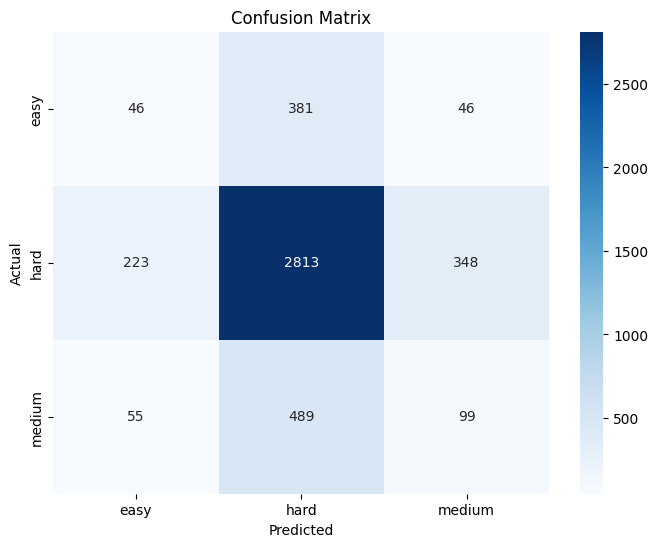

In [6]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 6. Save Model

In [7]:
os.makedirs('../models', exist_ok=True)
joblib.dump(model, '../models/model.joblib')
joblib.dump(vectorizer, '../models/vectorizer.joblib')
print("Model and Vectorizer saved successfully!")

Model and Vectorizer saved successfully!


# Analytics & Visual Insights for Questions and Difficulty
This section covers:
- Distribution of question difficulty levels
- Accuracy per question
- Hardest questions (lowest accuracy)
- Visualizations for Streamlit integration

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [9]:
questions=pd.read_csv('../data/reduced/Questions.csv')
answers=pd.read_csv('../data/reduced/Answers.csv')

In [10]:
bins=[-float('inf'),0,10,30,float('inf')]
labels=['Very_Hard','Hard','Medium','Easy']
questions['Difficulty']=pd.cut(questions['Score'],bins=bins,labels=labels)
difficulty_dist=questions['Difficulty'].value_counts()
difficulty_dist

Difficulty
Hard         9195
Very_Hard    2212
Medium       2037
Easy         1556
Name: count, dtype: int64

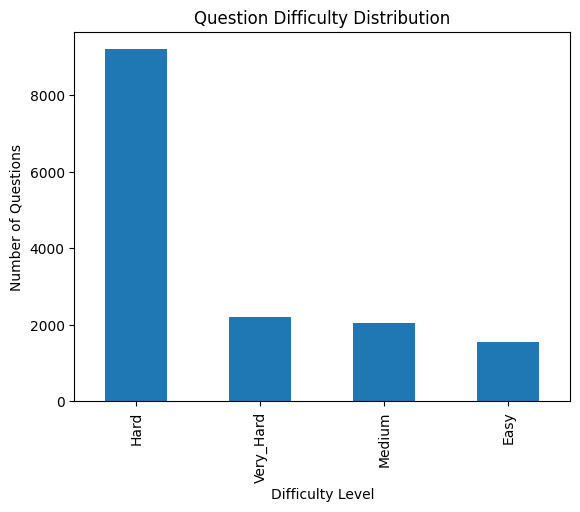

In [11]:
fig,ax=plt.subplots()
difficulty_dist.plot(kind='bar',ax=ax)
ax.set_title('Question Difficulty Distribution')
ax.set_xlabel('Difficulty Level')
ax.set_ylabel('Number of Questions')
plt.show()
fig_pie = px.pie(difficulty_dist, values=difficulty_dist.values,names=difficulty_dist.index,title='Difficulty Distribution')
fig_pie.show()

In [12]:
accuracy = answers.groupby('ParentId')['Score'].mean()
accuracy

ParentId
469        4.750000
502       12.000000
535       12.833333
594       15.333333
683        6.857143
            ...    
778660     0.000000
778965     2.000000
778969     5.000000
779495    11.500000
779675     6.333333
Name: Score, Length: 4349, dtype: float64

In [13]:
fig_acc = px.bar(accuracy,title='Per-Question Accuracy',labels={'value':'Accuracy','index':'Question Id'})
fig_acc.show()

In [14]:
n_hardest=10
hardest=accuracy.nsmallest(n_hardest)
hardest

ParentId
688245   -17.000000
183042   -15.000000
688766    -1.500000
284115    -1.000000
336753    -1.000000
304256    -0.500000
51658     -0.333333
657868    -0.250000
17250      0.000000
116894     0.000000
Name: Score, dtype: float64

In [15]:
hardest_questions_table=questions[questions['Id'].isin(hardest.index)][['Id', 'Title', 'Score', 'Difficulty']]
hardest_questions_table

,Id,Title,Score,Difficulty
43,17250,Create an encrypted ZIP file in Python,24,Medium
180,51658,Cross-platform space remaining on volume using...,56,Easy
410,116894,Best practices for manipulating database resul...,3,Hard
725,183042,How can I use UUIDs in SQLAlchemy?,26,Medium
1237,284115,Cross platform hidden file detection,13,Medium
1355,304256,What's the best way to find the inverse of dat...,36,Easy
1539,336753,Django FormWizard and Admin application,3,Hard
3525,657868,How do I find the modules that are available f...,2,Hard
3742,688245,Is there a better Python bundle for textmate t...,17,Medium
3746,688766,Getting 401 on Twitter OAuth POST requests,6,Hard


## Packaged Analytics Functions for Streamlit Integration
These functions are reusable and can be imported into a Streamlit app for easy integration.

In [16]:
def compute_difficulty_distribution(questions_df):
    bins = [-float('inf'), 0, 10, 30, float('inf')]
    labels = ['Very_Hard', 'Hard', 'Medium', 'Easy']
    questions_df_copy = questions_df.copy()
    questions_df_copy['Difficulty'] = pd.cut(questions_df_copy['Score'], bins=bins, labels=labels)
    return questions_df_copy['Difficulty'].value_counts()

In [17]:
def plot_difficulty_distribution(difficulty_dist):
    fig_bar, ax = plt.subplots(figsize=(10, 6))
    difficulty_dist.plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title('Question Difficulty Distribution', fontsize=14, fontweight='bold')
    ax.set_xlabel('Difficulty Level', fontsize=12)
    ax.set_ylabel('Number of Questions', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    fig_pie = px.pie(difficulty_dist, values=difficulty_dist.values,names=difficulty_dist.index,
                      title='Difficulty Distribution (%)',hole=0.3)
    
    return fig_bar,fig_pie

In [18]:
def compute_accuracy_per_question(answers_df):
    return answers_df.groupby('ParentId')['Score'].mean()

In [19]:
def plot_accuracy_per_question(accuracy_series, top_n=50):
    top_accuracy = accuracy_series.head(top_n).sort_values(ascending=False)
    fig = px.bar(top_accuracy, 
                 title=f'Top {top_n} Questions by Accuracy Score',
                 labels={'value':'Accuracy Score','index':'Question ID'},
                 color='value',color_continuous_scale='Viridis')
    fig.update_layout(height=600, showlegend=False)
    return fig

In [20]:

def get_hardest_questions(accuracy_series, n=10):
    return accuracy_series.nsmallest(n)

In [21]:

def create_hardest_questions_table(questions_df, accuracy_series, n=10):
    hardest = get_hardest_questions(accuracy_series, n)
    table = questions_df[questions_df['Id'].isin(hardest.index)][['Id', 'Title', 'Score']].copy()
    table['Accuracy_Score'] = table['Id'].map(hardest)
    table = table.sort_values('Accuracy_Score')
    return table[['Id', 'Title', 'Score', 'Accuracy_Score']]

## Export Visualizations & Data for UI Integration
Save all outputs (figures and dataframes) for Person 4 to use in Streamlit app.

✓ All analytics outputs generated successfully!


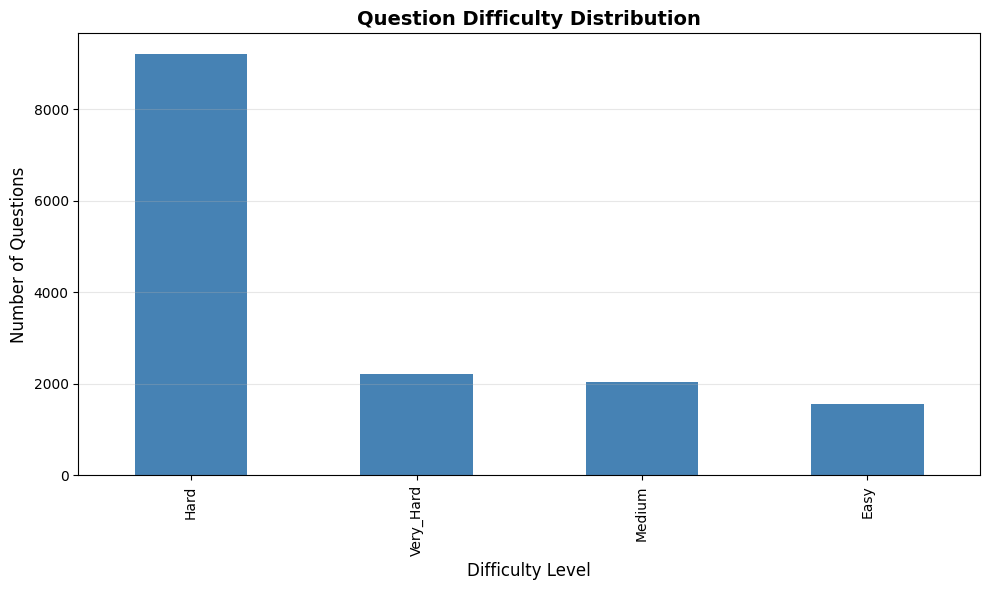

In [22]:
diff_dist = compute_difficulty_distribution(questions)
fig_bar, fig_pie = plot_difficulty_distribution(diff_dist)

accuracy_scores = compute_accuracy_per_question(answers)
fig_accuracy = plot_accuracy_per_question(accuracy_scores, top_n=50)

hardest_table = create_hardest_questions_table(questions, accuracy_scores, n=15)

print("✓ All analytics outputs generated successfully!")

In [23]:
import os
output_dir = '../outputs'
os.makedirs(output_dir, exist_ok=True)
fig_bar.savefig(f'{output_dir}/difficulty_distribution_bar.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_dir}/difficulty_distribution_bar.png")
fig_pie.write_html(f'{output_dir}/difficulty_distribution_pie.html')
print(f"✓ Saved: {output_dir}/difficulty_distribution_pie.html")
fig_accuracy.write_html(f'{output_dir}/accuracy_per_question.html')
print(f"✓ Saved: {output_dir}/accuracy_per_question.html")

✓ Saved: ../outputs/difficulty_distribution_bar.png
✓ Saved: ../outputs/difficulty_distribution_pie.html
✓ Saved: ../outputs/accuracy_per_question.html


In [ ]:
diff_dist.to_csv(f'{output_dir}/difficulty_distribution.csv')
print(f"✓ Saved: {output_dir}/difficulty_distribution.csv")
accuracy_scores.to_csv(f'{output_dir}/accuracy_per_question.csv')
print(f"✓ Saved: {output_dir}/accuracy_per_question.csv")
hardest_table.to_csv(f'{output_dir}/hardest_questions.csv', index=False)
print(f"✓ Saved: {output_dir}/hardest_questions.csv")
print("\n✅ All outputs ready for UI integration!")

✓ Saved: ../outputs/difficulty_distribution.csv
✓ Saved: ../outputs/accuracy_per_question.csv
✓ Saved: ../outputs/hardest_questions.csv

✅ All outputs ready for UI integration!
